In [1]:
import nrrd
import numpy as np
from utils import imshow

# readdata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation.seg.nrrd')
readdata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation-label.nrrd')
image, header2 = nrrd.read('../data/1241031155/9.40CHESTABDPELVIS.nrrd')

(512, 512, 1)
(512, 512, 1)
(1, 512, 512, 1)
(1, 512, 512, 1)
[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]]


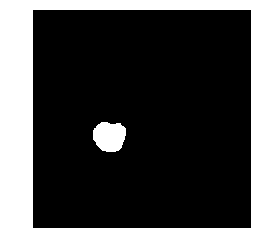

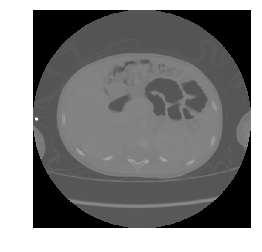

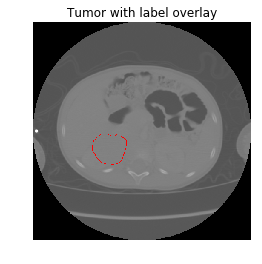

In [13]:
# print(readdata.shape)
# print(header)

lbl = readdata[...,[132]]
img = image[...,[132]]



print(img.shape)
print(lbl.shape)


# img.reshape(img.shape[2], img.shape[0], img.shape[1])

img = np.swapaxes(img, 0, 2)
lbl = np.swapaxes(lbl, 0, 2)

img = np.expand_dims(img, axis=3)
lbl = np.expand_dims(lbl, axis=3)

print(img.shape)
print(lbl.shape)


imshow(lbl)
imshow(img)
imshow(dat=img, lbl=lbl, title='Tumor with label overlay')

In [3]:
import tensorflow as tf


X = tf.placeholder(tf.float32, [None, 512, 512, 1])

# errors because it expects X to be 4-d
conv = tf.layers.conv2d(X, filters=8, kernel_size=(3, 3), padding='same')

# The input images in the variable `dat` are matrices of shape `1 x 240 x 240 x 4`.
# should we reshape our data to be 4D as well? ie to become something like 1 x 512 x 512 x 1


relu = tf.nn.relu(conv)
pool = tf.layers.max_pooling2d(relu, pool_size=(2, 2), strides=(4, 4))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

output = sess.run(pool, feed_dict={X: img})

print(output.shape)

(1, 128, 128, 8)


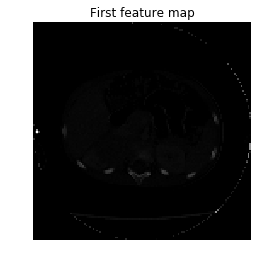

In [4]:
imshow(output[..., 0], title='First feature map')


In [5]:
sess.close()


In [6]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 512, 512, 1], name='X')
y = tf.placeholder(tf.int32, shape=[None], name='y')
mode = tf.placeholder(tf.bool, name='mode')

In [7]:
import net

In [8]:
pred = net.create_classifier2(X, training=mode)
print(pred.shape)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=pred)

(?, 2)


In [9]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)
print(lbl.shape)

(1, 512, 512, 1)


(1, 512, 512, 1)
(1, 512, 512, 1)
REAL (tumor, y/n?): y
PRED (tumor, y/n?): n
LOSS (lower value is better prediction): 3.518460


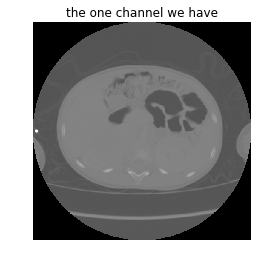

[1]


In [10]:
# dat, lbl = data.load(mode='train', n=1)
print(img.shape)
print(lbl.shape)
lbl = np.max(lbl > 0, axis=(1,2,3)).astype('int32')
sce, logits = sess.run([loss, pred], {X: img, y: lbl, mode: True})

print('REAL (tumor, y/n?): %s' % ('y' if lbl else 'n'))
print('PRED (tumor, y/n?): %s' % ('y' if logits[0, 1] > logits[0, 0] else 'n'))
print('LOSS (lower value is better prediction): %f' % sce)

imshow(img[..., 0], title='the one channel we have')
print(lbl)

In [11]:
sess.close()